# Data visualisering av den historiske dataen 

### Oppgave 4: Data analyse 


In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from datetime import datetime
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates

In [83]:
# Velg by (Oslo, Tromsø, Stryn)
city_name = "Oslo"
filepath = f"../../data/{city_name}.csv"

In [84]:
def gjør_klar_data(city_name, file_path):
    df = pd.read_csv(file_path, sep=';')
    city_data = df[df['Navn'].str.contains(city_name, case=False)].copy()
    
    if city_data.empty:
        return None, f"No data found for {city_name}"
    
    numeric_columns = ['Nedbør (1 t)', 'Lufttemperatur', 'Middelvind', 'Snødybde', 'Relativ luftfuktighet']
    for col in numeric_columns:
        city_data.loc[:,col] = city_data[col].astype(str).replace('-', 'NaN').str.replace(',', '.')
        city_data.loc[:,col] = pd.to_numeric(city_data[col], errors='coerce')
    
    city_data['Tid(norsk normaltid)'] = pd.to_datetime(city_data['Tid(norsk normaltid)'], format='%d.%m.%Y %H:%M')
    return city_data, None

In [85]:
def calculate_weather_stats(city_name, file_path):
    
    city_data, error = gjør_klar_data(city_name, file_path)
    
    if error:
        print(error)
        return None
    
    # Definerer kolonnene som skal brukes i analysen
    numeric_columns = ['Nedbør (1 t)', 'Lufttemperatur', 'Middelvind', 'Snødybde', 'Relativ luftfuktighet']
    
    # Beregner statistikkene 
    stats = {}
    for column in numeric_columns:
        stats[column] = {
            'Mean': round(city_data[column].mean(), 2),
            'Median': round(city_data[column].median(), 2),
            'Std Dev': round(city_data[column].std(), 2)
        }

    # Lager tabellen med PrettyTable
    table = PrettyTable()
    table.field_names = ["Værdata for "+ city_name +":", "Gjennomsnitt", "Median", "Std Dev"]
    
    
    for parameter, values in stats.items():
        table.add_row([
            parameter,
            f"{values['Mean']:.2f}",
            f"{values['Median']:.2f}",
            f"{values['Std Dev']:.2f}"
        ])
    
    
    table.align["Værdata for "+ city_name +":"] = "l"  
    table.align["Gjennomsnitt"] = "r"      
    table.align["Median"] = "r"
    table.align["Std Dev"] = "r"
    
    print(table)


#calculate_weather_stats(city_name, filepath)
        

In [86]:
def plot_correlation_temperature_wind(city_name, file_path):
    
    city_data, error = gjør_klar_data(city_name, file_path)

    if error:
        print(error)
        return None

    # Skjekker om det er manglende data
    city_data = city_data.dropna(subset=["Lufttemperatur", "Middelvind"])

    # Beregner korrelasjonen mellom lufttemperatur og middelvind
    correlation = city_data["Nedbør (1 t)"].corr(city_data["Relativ luftfuktighet"])

    # Plot
    fig = px.scatter(
        city_data,
        x="Nedbør (1 t)",
        y="Relativ luftfuktighet",
        title=f"Korelasjon mellom temperatur og vindhastighet i Oslo {city_name} (2024)",
        labels={"Lufttemperatur": "Lufttemperatur (°C)", "Middelvind": "Middelvind (m/s)"},
        color_discrete_sequence=['blue']
    )

    # Oppdaterer layout og stil
    fig.update_traces(marker=dict(size=5, opacity=0.5)) # Juster størrelsen på punktene
    fig.update_layout(
        xaxis_title="Lufttemperatur (°C)",
        yaxis_title="Middelvind (m/s)",
        showlegend=False,
        title_x=0.5,  # Sentrer tittelen 
        margin=dict(l=50, r=50, t=100, b=50)  # Legg til marginer for bedre plassering
    )

    
    fig.show()

plot_correlation_temperature_wind(city_name, filepath)

In [87]:
def plot_Temperature(city_name, file_path):

    city_data, error = gjør_klar_data(city_name, file_path)

    if error:
        print(error)
        return None

    city_data['Date'] = city_data["Tid(norsk normaltid)"].dt.date
    daily_avg_temp = city_data.groupby('Date')['Lufttemperatur'].mean().reset_index()
    daily_avg_temp['Date'] = pd.to_datetime(daily_avg_temp['Date'])
    
    fig = px.line(daily_avg_temp, x='Date', y='Lufttemperatur', 
                 title=f'Lufttemperatur over tid for {city_name} (Jan 2024 - Des 2024)',
                 labels={'Lufttemperatur': 'Temperatur (°C)', 'Date': 'Tid'},
                 line_shape='linear', color_discrete_sequence=['blue'])
    
    fig.update_layout(
        xaxis_title="Dato",
        yaxis_title="Luftemperatur (°C)",
        xaxis_tickangle=45,
        showlegend=False,
        title_x=0.5,  # Sentrer tittelen 
        #bargap=0.1    
    )
    
    fig.show()
    
plot_Temperature(city_name, filepath)

In [88]:
def plot_Wind(city_name, file_path):
    
        city_data, error = gjør_klar_data(city_name, file_path)
    
        if error:
            print(error)
            return None
    
        city_data['Date'] = city_data["Tid(norsk normaltid)"].dt.date
        daily_avg_wind = city_data.groupby('Date')['Middelvind'].mean().reset_index()
        daily_avg_wind['Date'] = pd.to_datetime(daily_avg_wind['Date'])
        
        # Plotter den daglige gjennomsnittlige vindhastigheten
        plt.figure(figsize=(10, 5))
        plt.plot(daily_avg_wind["Date"], daily_avg_wind["Middelvind"], 
                label="Middelvei vind (døgn)", color='r')
        
        # Fomaterer plottet
        plt.xlabel("Tid")
        plt.ylabel("Vindhastighet (m/s)")
        plt.title(f"Middelvei vind over tid for {city_name} (Jan 2024 - Des 2024)")
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


#plot_Wind(city_name, filepath)

In [89]:
def plot_fuktighet(city_name, file_path):
    
        city_data, error = gjør_klar_data(city_name, file_path)
    
        if error:
            print(error)
            return None
    
        city_data['Date'] = city_data["Tid(norsk normaltid)"].dt.date
        daily_avg_humidity = city_data.groupby('Date')['Relativ luftfuktighet'].mean().reset_index()
        daily_avg_humidity['Date'] = pd.to_datetime(daily_avg_humidity['Date'])
        
        sns.set_style("whitegrid")  
    
        # Lager plottet med seaborn
        plt.figure(figsize=(10, 5))
        sns.lineplot(x="Date", y="Relativ luftfuktighet", data=daily_avg_humidity, 
                 label="Middelvei fuktighet (døgn)", color='g', linewidth=2)
    
        # Formaterer plottet
        plt.xlabel("Tid")
        plt.ylabel("Luftfuktighet (%)")
        plt.title(f"Luftfuktighet over tid for {city_name} (Jan 2024 - Des 2024)", fontsize=14)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

#plot_fuktighet(city_name, filepath)

In [107]:
def plot_nedbør_bar(city_name, file_path):
    
    city_data, error = gjør_klar_data(city_name, file_path)
    if error:
        print(error)
        return None
    
    # Beregner nedbør per dag for å gjøre grafen smoothere
    city_data['Date'] = city_data['Tid(norsk normaltid)'].dt.date
    daily_precip = city_data.groupby('Date')['Nedbør (1 t)'].sum().reset_index()
    daily_precip['Date'] = pd.to_datetime(daily_precip['Date'])
    
    # Prøver å lage en bar plot med Plotly
    fig = px.bar(daily_precip, x='Date', y='Nedbør (1 t)', 
                 title=f'Daglig Nedbør for {city_name} (Jan 2024 - Des 2024)',
                 labels={'Date': 'Dato', 'Nedbør (1 t)': 'Total Nedbør (mm)'},
                 color_discrete_sequence=['skyblue'])
    
    # Formetterer plottet
    fig.update_layout(
        xaxis_title="Dato",
        yaxis_title="Total Nedbør (mm)",
        xaxis_tickangle=45,
        showlegend=False,
        title_x=0.5,  # Sentrer tittelen
        bargap=0.1  
    )
    
    fig.show()


plot_nedbør_bar(city_name, filepath)


Evaluering av modellen for Oslo:
Mean Squared Error (MSE): 58.43
R² Score: 0.17
Koeffisienter: [ 0.02514482 -0.16410176]
Intercept: 15.963603787765228


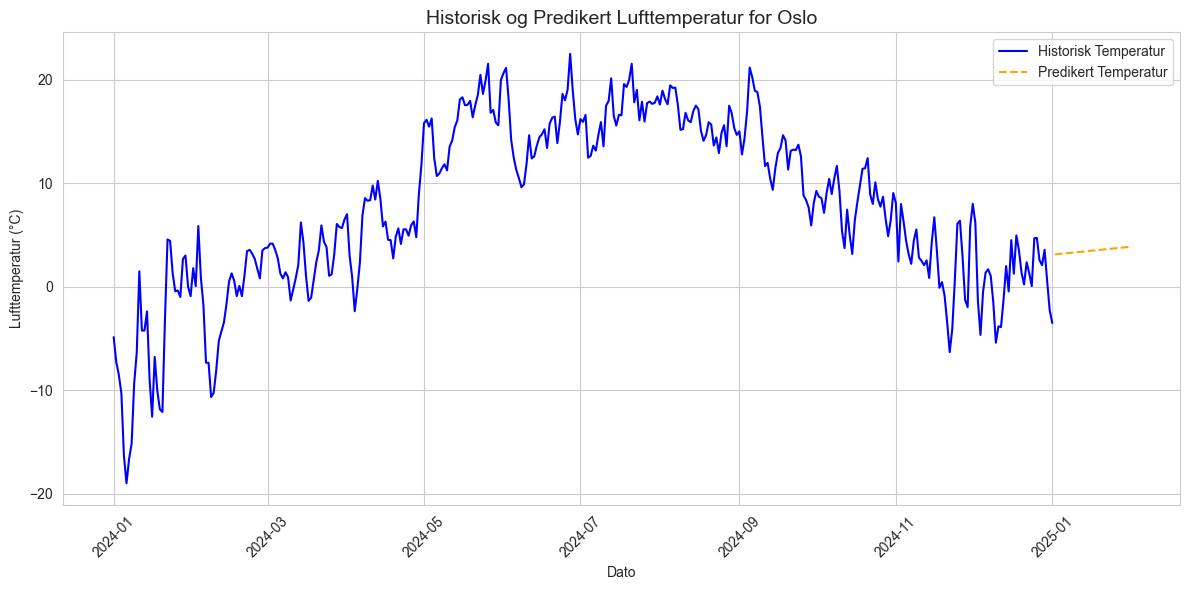

In [97]:
def predictive_analysis_temperature(city_name, file_path):
    # Last inn og forbered data
    city_data, error = gjør_klar_data(city_name, file_path)
    if error:
        print(error)
        return None
    
    # --- Trinn 1: Forbered dataene ---
    # Legg til en kolonne for dag nummer i året (numerisk verdi for tid)
    city_data['Date'] = city_data['Tid(norsk normaltid)'].dt.date
    city_data['DayOfYear'] = city_data['Tid(norsk normaltid)'].dt.dayofyear
    
    # Velg funksjoner (features) og målverdi (target)
    # Features: DayOfYear (tid), Relativ luftfuktighet (kan påvirke temperatur)
    # Target: Lufttemperatur
    features = ['DayOfYear', 'Relativ luftfuktighet']
    target = 'Lufttemperatur'
    
    # Håndter manglende verdier
    # Fjern rader med manglende verdier i de valgte kolonnene
    data = city_data[features + [target]].dropna()
    
    if data.empty:
        print(f"Ingen data tilgjengelig for {city_name} etter fjerning av manglende verdier.")
        return None
    
    # Definer X (features) og y (target)
    X = data[features]
    y = data[target]
    
    # Del dataene i trenings- og testsett (80% trening, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # --- Trinn 2: Tren lineær regresjonsmodell ---
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Gjør prediksjoner på testsettet
    y_pred = model.predict(X_test)
    
    # --- Trinn 3: Evaluer modellens ytelse ---
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Evaluering av modellen for {city_name}:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"Koeffisienter: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    
    # --- Trinn 4: Gjør prediksjoner for fremtiden ---
    # Lag et fremtidig datasett for de neste 30 dagene etter siste dato i dataene
    last_date = city_data['Tid(norsk normaltid)'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    future_days = [(date - city_data['Tid(norsk normaltid)'].min()).days for date in future_dates]
    
    # Bruk gjennomsnittlig luftfuktighet for prediksjon (for enkelhet)
    avg_humidity = city_data['Relativ luftfuktighet'].mean()
    future_data = pd.DataFrame({
        'DayOfYear': [(date.timetuple().tm_yday) for date in future_dates],
        'Relativ luftfuktighet': [avg_humidity] * 30
    })
    
    # Gjør prediksjoner
    future_predictions = model.predict(future_data)
    
    # --- Trinn 5: Visualiser resultater ---
    # Plot historiske data og prediksjoner
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Historiske daglige gjennomsnitt
    daily_avg_temp = city_data.groupby('Date')['Lufttemperatur'].mean().reset_index()
    plt.plot(daily_avg_temp['Date'], daily_avg_temp['Lufttemperatur'], label='Historisk Temperatur', color='blue')
    
    # Prediksjoner
    future_df = pd.DataFrame({'Date': future_dates, 'Lufttemperatur': future_predictions})
    plt.plot(future_df['Date'], future_df['Lufttemperatur'], label='Predikert Temperatur', color='orange', linestyle='--')
    
    plt.title(f'Historisk og Predikert Lufttemperatur for {city_name}', fontsize=14)
    plt.xlabel('Dato')
    plt.ylabel('Lufttemperatur (°C)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


predictive_analysis_temperature(city_name, filepath)

C:\Users\User\AppData\Local\Temp\ipykernel_11420\581172387.py:25: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Prediksjon av Lufttemperatur for Oslo:
Mean Squared Error (MSE): 58.38
R² Score: 0.20


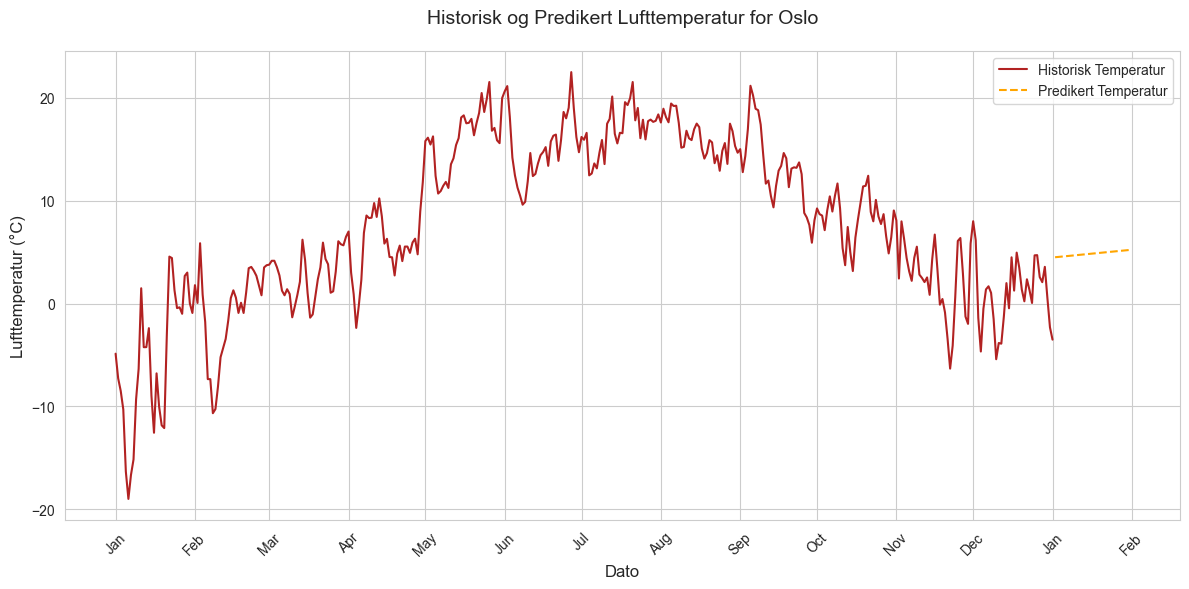

In [104]:
# Hovedfunksjon som kaller de tre prediksjons- og visualiseringsfunksjonene
def predict_and_visualize_weather(city_name, file_path):
    # Last inn og forbered data
    city_data, error = gjør_klar_data(city_name, file_path)
    if error:
        print(error)
        return None
    
    # Legg til hjelpekolonner for prediksjon og plotting
    city_data['Date'] = city_data['Tid(norsk normaltid)'].dt.date
    city_data['DayOfYear'] = city_data['Tid(norsk normaltid)'].dt.dayofyear
    city_data['Hour'] = city_data['Tid(norsk normaltid)'].dt.hour
    
    # Kall de tre prediksjons- og visualiseringsfunksjonene
    predict_temperature(city_data, city_name)
   
# Funksjon for å predikere og visualisere Lufttemperatur (Linjediagram)
def predict_temperature(city_data, city_name):
    features = ['DayOfYear', 'Hour', 'Relativ luftfuktighet']
    target = 'Lufttemperatur'
    
    # Håndter manglende verdier ved å imputere med gjennomsnitt
    data = city_data.copy()
    for col in features + [target]:
        data[col] = data[col].fillna(data[col].mean())
    
    X = data[features]
    y = data[target]
    
    # Del data i trenings- og testsett
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tren modellen
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluer modellen
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Prediksjon av Lufttemperatur for {city_name}:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Gjør fremtidige prediksjoner (neste 30 dager)
    last_date = city_data['Tid(norsk normaltid)'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    avg_humidity_by_hour = city_data.groupby('Hour')['Relativ luftfuktighet'].mean()
    future_hour = 12
    future_humidity = avg_humidity_by_hour.get(future_hour, city_data['Relativ luftfuktighet'].mean())
    
    future_data = pd.DataFrame({
        'DayOfYear': [(date.timetuple().tm_yday) for date in future_dates],
        'Hour': [future_hour] * 30,
        'Relativ luftfuktighet': [future_humidity] * 30
    })
    future_predictions = model.predict(future_data)
    
    # Visualiser: Linjediagram
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Historiske daglige gjennomsnitt
    daily_avg_temp = city_data.groupby('Date')['Lufttemperatur'].mean().reset_index()
    daily_avg_temp['Date'] = pd.to_datetime(daily_avg_temp['Date'])
    plt.plot(daily_avg_temp['Date'], daily_avg_temp['Lufttemperatur'], label='Historisk Temperatur', color='firebrick')
    
    # Fremtidige prediksjoner
    future_df = pd.DataFrame({'Date': future_dates, 'Lufttemperatur': future_predictions})
    plt.plot(future_df['Date'], future_df['Lufttemperatur'], label='Predikert Temperatur', color='orange', linestyle='--')
    
    plt.title(f'Historisk og Predikert Lufttemperatur for {city_name}', fontsize=14, pad=20)
    plt.xlabel('Dato', fontsize=12)
    plt.ylabel('Lufttemperatur (°C)', fontsize=12)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.show()


predict_and_visualize_weather(city_name, filepath)

In [110]:
import plotly.graph_objects as go
def predict_and_plot_nedbør_bar(city_name, file_path):
    # Last inn og forbered data
    city_data, error = gjør_klar_data(city_name, file_path)
    if error:
        print(error)
        return None
    
    # Legg til hjelpekolonner for prediksjon og plotting
    city_data['Date'] = city_data['Tid(norsk normaltid)'].dt.date
    city_data['DayOfYear'] = city_data['Tid(norsk normaltid)'].dt.dayofyear
    city_data['Hour'] = city_data['Tid(norsk normaltid)'].dt.hour
    
    # --- Trinn 1: Forbered historiske data ---
    # Beregn daglig nedbør for historiske data
    daily_precip = city_data.groupby('Date')['Nedbør (1 t)'].sum().reset_index()
    daily_precip['Date'] = pd.to_datetime(daily_precip['Date'])
    daily_precip['Type'] = 'Historisk'  # Marker som historiske data
    
    # --- Trinn 2: Prediksjon av fremtidig nedbør ---
    # Velg funksjoner og målverdi
    features = ['DayOfYear', 'Hour', 'Relativ luftfuktighet']
    target = 'Nedbør (1 t)'
    
    # Håndter manglende verdier ved å imputere med gjennomsnitt
    data = city_data.copy()
    for col in features + [target]:
        data[col] = data[col].fillna(data[col].mean())
    
    X = data[features]
    y = data[target]
    
    # Del data i trenings- og testsett
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tren modellen
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluer modellen
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Prediksjon av Nedbør for {city_name}:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Gjør fremtidige prediksjoner for mars 2025 (1. mars til 31. mars)
    last_date = city_data['Tid(norsk normaltid)'].max()  # Forventet 1. mars 2025
    future_dates = pd.date_range(start=last_date, end='2025-03-31', freq='D')  # 1. mars til 31. mars
    
    # Bruk gjennomsnittlig luftfuktighet for kl. 12:00
    avg_humidity_by_hour = city_data.groupby('Hour')['Relativ luftfuktighet'].mean()
    future_hour = 12
    future_humidity = avg_humidity_by_hour.get(future_hour, city_data['Relativ luftfuktighet'].mean())
    
    future_data = pd.DataFrame({
        'DayOfYear': [(date.timetuple().tm_yday) for date in future_dates],
        'Hour': [future_hour] * len(future_dates),
        'Relativ luftfuktighet': [future_humidity] * len(future_dates)
    })
    future_predictions = model.predict(future_data)
    
    # Lag en DataFrame for predikerte data
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Nedbør (1 t)': future_predictions,
        'Type': 'Predikert'
    })
    
    # --- Trinn 3: Kombiner historiske og predikerte data ---
    combined_df = pd.concat([daily_precip, future_df], ignore_index=True)
    
    # --- Trinn 4: Visualiser med Plotly ---
    # Bruk go.Figure for å kunne tilpasse farger basert på Type
    fig = go.Figure()
    
    # Legg til historiske data
    fig.add_trace(go.Bar(
        x=combined_df[combined_df['Type'] == 'Historisk']['Date'],
        y=combined_df[combined_df['Type'] == 'Historisk']['Nedbør (1 t)'],
        name='Historisk Nedbør',
        marker_color='skyblue'
    ))
    
    # Legg til predikerte data
    fig.add_trace(go.Bar(
        x=combined_df[combined_df['Type'] == 'Predikert']['Date'],
        y=combined_df[combined_df['Type'] == 'Predikert']['Nedbør (1 t)'],
        name='Predikert Nedbør',
        marker_color='orange'
    ))
    
    # Formater plottet
    fig.update_layout(
        title=f'Daglig Nedbør for {city_name} (Jan 2024 - Mar 2025)',
        xaxis_title="Dato",
        yaxis_title="Total Nedbør (mm)",
        xaxis_tickangle=45,
        title_x=0.5,  # Sentrer tittelen
        bargap=0.1,
        xaxis=dict(
            tickformat='%d. %b %Y',  # Format: "01. Mar 2025"
            tickmode='auto',
            nticks=20  # Juster antall tikker for å unngå rot
        ),
        legend=dict(
            x=0.01,
            y=0.99,
            bgcolor='rgba(255, 255, 255, 0.5)',
            bordercolor='Black',
            borderwidth=1
        )
    )
    
    fig.show()

predict_and_plot_nedbør_bar(city_name, filepath)


Prediksjon av Nedbør for Oslo:
Mean Squared Error (MSE): 0.94
R² Score: 0.02


C:\Users\User\AppData\Local\Temp\ipykernel_11420\466885081.py:28: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

